In [10]:
import ROOT as rt
import csv
import re
import sys
import collections
from collections import OrderedDict
import uproot
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
from numpy import linalg as LA
from ROOT import TLorentzVector
from array import array
# import PyTEX
import os

import math
import random
from optparse import OptionParser

sys.path.append('/storage/user/jmao/gpu/jmao/cms-llp/delayed_jet_analyzer/lib/')

from histo_utilities import create_TH1D, create_TH2D, create_TGraph,std_color_list, make_ratio_plot

import CMS_lumi, tdrstyle 
tdrstyle.setTDRStyle()
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText = "     Simulation Preliminary"

     
print(sys.version)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score
import pandas as pd
import pickle as pickle
import shlex
import uproot
import seaborn as sns

from scipy.spatial.distance import cdist
from collections import Counter 
import datetime
import pytz

from prettytable import PrettyTable
from pyjet import cluster

import xgboost as xgb
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBClassifier


3.6.8 (default, Apr  2 2020, 13:34:55) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


In [11]:
# root settings
rt.gROOT.SetBatch(True)
rt.gStyle.SetOptStat(0)
rt.gStyle.SetOptFit(111)
rt.gStyle.SetPaintTextFormat("2.1f")

# plt.rcParams["font.family"] = "Arial"
plt.rcParams["axes.unicode_minus"] = False
plt.rcParams["text.usetex"] = False
plt.rcParams["mathtext.fontset"] = "cm"

# test_name = 'xgb_HH_vs_QCD_ebBDT'

lumi_sf_sig = 137.0 # scale lumi from sample to full run2
lumi_sf_bkg = 137.0

#output dir
 
 
plotDir = '/storage/user/jmao/gpu/jmao/cms-llp/plots/20201105/2018/MC/'

os.system("mkdir -p "+ plotDir)

0

In [3]:
tags = []
tags = [
    
#         'QCD_HT_all, background',
#         'WLNu_HT_all, background',
#         'ZNunu_HT_all, background',
#         'TT_Lep, background',

        ]


# directory
home_dir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/'
# file names

fnames = {}

 
fnames['QCD_HT_all, background'] = 'V1p17/v21/MC_Fall18/normalized/QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['WLNu_HT_all, background'] = 'V1p17/v21/MC_Fall18/normalized/WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
fnames['ZNunu_HT_all, background'] = 'V1p17/v21/MC_Fall18/normalized/ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
fnames['TT_Lep, background'] = 'V1p17/v21/MC_Fall18/normalized/TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'


# get all the trees
tree = OrderedDict()

for tag in tags:
    print(home_dir+fnames[tag])

    root_dir = uproot.open(home_dir+fnames[tag])
    tree[tag] = root_dir['SusyLLPTree']

    print ('Open ready')
    print(tag)
    print ('Tree ready')
    print(tree[tag], tree)
    v = tree[tag]
    jet_amax = v['jetGammaMax_ET'].array()
    print(jet_amax[:10])
    jet_amax = v['weight'].array()
    print(jet_amax[:10])
    print(np.unique(jet_amax))
     


In [12]:
# signal and bkg file normalized
dataDir = '/mnt/hadoop/store/group/phys_exotica/delayedjets/displacedJetTimingAnalyzer/V1p17/v21/MC_Fall18/normalized/'
#sig 
signalFileName = dataDir + 'n3n2-n1-hbb-hbb_mh200_pl1000_ev100000_1pb_weighted.root'
signalFile = rt.TFile(signalFileName)
# signalTree = signalFile.Get('BDT_Tree')
signalTree = signalFile.Get('SusyLLPTree')
signalEvents = lumi_sf_sig*signalTree.GetEntries()

#bkg
# bkgFileName    = dataDir + 'QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
# bkgFile = rt.TFile(bkgFileName)
# # bkgTree = bkgFile.Get('BDT_Tree')
# bkgTree = bkgFile.Get('SusyLLPTree')
# bkgEvents = lumi_sf_bkg*bkgTree.GetEntries()

bkg1FileName    = dataDir + 'QCD_HT50toInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
bkg2FileName    = dataDir + 'WJetsToLNu_HT-70ToInf_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'
bkg3FileName    = dataDir + 'ZJetsToNuNu_HT-100ToInf_13TeV-madgraph_1pb_weighted.root'
bkg4FileName    = dataDir + 'TTJets_TuneCP5_13TeV-madgraphMLM-pythia8_1pb_weighted.root'

bkg1File = rt.TFile(bkg1FileName)
# bkgTree = bkgFile.Get('BDT_Tree')
bkg1Tree = bkg1File.Get('SusyLLPTree')
bkg1Events = lumi_sf_bkg*bkg1Tree.GetEntries()

bkg2File = rt.TFile(bkg2FileName)
bkg2Tree = bkg2File.Get('SusyLLPTree')
bkg2Events = lumi_sf_bkg*bkg2Tree.GetEntries()

bkg3File = rt.TFile(bkg3FileName)
bkg3Tree = bkg3File.Get('SusyLLPTree')
bkg3Events = lumi_sf_bkg*bkg3Tree.GetEntries()

bkg4File = rt.TFile(bkg4FileName)
bkg4Tree = bkg4File.Get('SusyLLPTree')
bkg4Events = lumi_sf_bkg*bkg4Tree.GetEntries()

print(bkg1Events)
print(bkg2Events)
print(bkg3Events)
print(bkg4Events)


70582674.0
1172420244.0
1144510056.0
2055218241.0
ReadStreamerInfo, class:string, illegal uid=-2
ReadStreamerInfo, class:string, illegal uid=-2
ReadStreamerInfo, class:string, illegal uid=-2
ReadStreamerInfo, class:string, illegal uid=-2


In [5]:
# variables = [
 
#         ['jetTime', 'jetTime', 'jetTime', 50, -10, 20],
#         ['jetDNNScore', 'jetDNNScore', 'jetDNNScore', 50, 0, 1],
        
#             ]

In [13]:
variablesX = [
 
        ['jetTime', 'jetTime', 'jetTime', 50, -10, 20],
#         ['jetDNNScore', 'jetDNNScore', 'jetDNNScore', 50, 0, 1],
        
            ]

In [14]:
variablesY = [
 
#         ['jetTime', 'jetTime', 'jetTime', 50, -10, 20],
        ['jetDNNScore', 'jetDNNScore', 'jetDNNScore', 50, 0, 1],
        
            ]

In [15]:
##Getting ROOT files into pandas
df_signalX = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesX], flatten=True)
df_signalY = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesY], flatten=True)

df_bkg1X = uproot.open(bkg1FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesX], flatten=True)
df_bkg2X = uproot.open(bkg2FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesX], flatten=True)
# df_bkg3X = uproot.open(bkg3FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesX], flatten=True)
# df_bkg4X = uproot.open(bkg4FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesX], flatten=True)
df_bkg1Y = uproot.open(bkg1FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesY], flatten=True)
df_bkg2Y = uproot.open(bkg2FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesY], flatten=True)
# df_bkg3Y = uproot.open(bkg3FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesY], flatten=True)
# df_bkg4Y = uproot.open(bkg4FileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesY], flatten=True)

# df_bkgX = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesX], flatten=True)
# df_bkgY = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variablesY], flatten=True)

# df_signal = uproot.open(signalFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
# df_bkg = uproot.open(bkgFileName)['SusyLLPTree'].pandas.df([row[0] for row in variables], flatten=True)
# df_signal = uproot.open(signalFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)
# df_bkg = uproot.open(bkgFileName)['BDT_Tree'].pandas.df([row[0] for row in variables], flatten=True)


KeyboardInterrupt: 

In [7]:
#weight
#sig
sig_root_dir = uproot.open(signalFileName) 
# sig_tree = sig_root_dir['BDT_Tree']
sig_tree = sig_root_dir['SusyLLPTree']
# #branches
sig_w = sig_tree['weight'].array() 
sig_jet_pt = sig_tree['jetPt'].array()
# sig_w = sig_tree['weight_'].array() 
# sig_jet_pt = sig_tree['jetPt_'].array()
from itertools import chain 
sig_flat_w = [np.array([x]*len(y)) for x,y in zip(sig_w,sig_jet_pt)]
sig_flat_w = list(chain.from_iterable(sig_flat_w))
sig_flat_w = [x*137000 for x in sig_flat_w]
# sig_w = sig_tree['flat_w'].array().flatten()
# bkg
bkg_root_dir = uproot.open(bkgFileName) 
# bkg_tree = bkg_root_dir['BDT_Tree']
bkg_tree = bkg_root_dir['SusyLLPTree']
# #branches
bkg_w = bkg_tree['weight'].array() 
bkg_jet_pt = bkg_tree['jetPt'].array()
# bkg_w = bkg_tree['weight_'].array() 
# bkg_jet_pt = bkg_tree['jetPt_'].array()
bkg_flat_w = [np.array([x]*len(y)) for x,y in zip(bkg_w,bkg_jet_pt)]
bkg_flat_w = list(chain.from_iterable(bkg_flat_w)) 
bkg_flat_w = [x*137000 for x in bkg_flat_w]
# bkg_w = bkg_tree['flat_w'].array().flatten()
# sample weight
# sample_w = np.concatenate([sig_flat_w,bkg_flat_w])

In [28]:
sample_w = np.concatenate([bkg_flat_w,sig_flat_w])
# sample_w = np.concatenate([sig_w,bkg_w])
print(sig_flat_w[0])
print(())
print(len(sig_flat_w))
print(len(sig_w))
print(len(sig_jet_pt))
print(len(sig_jet_pt.flatten()))

1.1042597825507983
()
6994
3502
3502
6994


In [9]:
## change nan to -999
df_signalX = df_signalX.fillna(-999)
df_signalY = df_signalY.fillna(-999)

df_bkg1X = df_bkg1X.fillna(-999)
df_bkg2X = df_bkg2X.fillna(-999)
df_bkg3X = df_bkg3X.fillna(-999)
df_bkg4X = df_bkg4X.fillna(-999)
df_bkg1Y = df_bkg1Y.fillna(-999)
df_bkg2Y = df_bkg2Y.fillna(-999)
df_bkg3Y = df_bkg3Y.fillna(-999)
df_bkg4Y = df_bkg4Y.fillna(-999)

# df_bkgX = df_bkgX.fillna(-999)
# df_bkgY = df_bkgY.fillna(-999)

# df_signal = df_signal.fillna(-999)
# df_bkg = df_bkg.fillna(-999)


In [17]:
##Getting a numpy array out of two pandas data frame

x = np.concatenate([df_bkg1X.values,df_bkg2X.values,df_bkg3X.values,df_bkg4X.values,df_signalX.values])
y = np.concatenate([df_bkg1Y.values,df_bkg2Y.values,df_bkg3Y.values,df_bkg4Y.values,df_signalY.values])
y_true = np.concatenate([np.zeros(len(df_bkg1X)),np.zeros(len(df_bkg2X)),np.zeros(len(df_bkg3X)),np.zeros(len(df_bkg4X)),
np.ones(len(df_signalX))])

# x = np.concatenate([df_bkgX.values,df_signalX.values])
# y = np.concatenate([df_bkgY.values,df_signalY.values])
# y_true = np.concatenate([np.zeros(len(df_bkg)),
# np.ones(len(df_signal))])

#getting a numpy array from two pandas data frames
# x = np.concatenate([df_bkg.values,df_signal.values])
#creating numpy array for target variables
# y = np.concatenate([np.zeros(len(df_bkg)),
# np.ones(len(df_signal))])

In [15]:
# split data into train and test sets
# seed = 7
# test_size = 0.4
# sample_size = 1.0
# x_train, x_test, y_train, y_test, w_train, w_test = train_test_split(x, y, sample_w, train_size = sample_size*(1-test_size), test_size=sample_size*test_size, random_state=seed)

In [29]:
#ROC 
# print(y[:])
# fpr, tpr, thr = roc_curve(y_true, y)
fpr, tpr, thr = roc_curve(y_true, y, sample_weight=sample_w)


In [21]:
AUC = roc_auc_score(y_true, y)

Text(1.0, 1.01, '13 TeV')

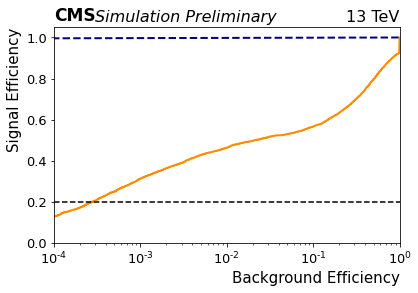

In [27]:
#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xscale('log')
plt.xlim([0.0001, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
# plt.text(0.02,0.31,'AUC = %.4f'%AUC, fontsize=12)
# plt.axhline(y=0.9, color="black", linestyle='--')
# plt.axvline(x=0.2, color="black", linestyle='--')
# plt.scatter(0.00045, 0.21271, marker='o')
plt.axhline(y=0.2, color="black", linestyle='--')
#plt.show()
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
# plt.savefig(plotDir+'training/myroc_' + test_name + '.png')
# os.system("chmod 755 "+plotDir+"training/*")

Text(1.0, 1.01, '13 TeV')

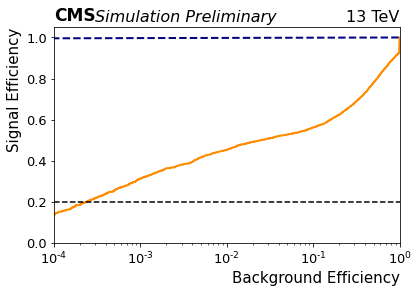

In [30]:
#plot roc curve
f = plt.figure()
ax = f.add_subplot(111)
plt.subplots_adjust(top=0.9, bottom=0.15, left=0.15, right=0.95)
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xscale('log')
plt.xlim([0.0001, 1.0])
plt.ylim([0.0, 1.05])
plt.ylabel('Signal Efficiency',horizontalalignment='right', y=1.0, fontsize=15)
plt.xlabel('Background Efficiency',horizontalalignment='right', x=1.0, fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13) 
# plt.text(0.02,0.31,'AUC = %.4f'%AUC, fontsize=12)
# plt.axhline(y=0.9, color="black", linestyle='--')
# plt.axvline(x=0.2, color="black", linestyle='--')
# plt.scatter(0.00045, 0.21271, marker='o')
plt.axhline(y=0.2, color="black", linestyle='--')
#plt.show()
plt.text(0.0, 1.01, "CMS", ha='left', va='bottom', transform=ax.transAxes, weight='bold', fontsize=17)
plt.text(0.12, 1.01, "Simulation Preliminary", ha='left', va='bottom', transform=ax.transAxes, style='italic', fontsize=16)
plt.text(1.0, 1.01, "13 TeV", ha='right', va='bottom', transform=ax.transAxes, fontsize=16)
# plt.savefig(plotDir+'training/myroc_' + test_name + '.png')
# os.system("chmod 755 "+plotDir+"training/*")

10 pfjetMinDeltaRPVTracks thre range 9.99 0.01
pfjetMinDeltaRPVTracks
ZNunu_HT_all, background 23821201
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.94883152 0.82712575 0.68423438 0.54910379 0.43292534 0.33781405
 0.26180359 0.20218019 0.15578584 0.11998439]
0.0
0.9488315245349691
0.0
[0.98753411 0.95675893 0.92481497 0.87612003 0.82547723 0.77834044
 0.73665752 0.69731196 0.65952463 0.62719121]
0.0
0.9875341135091955
1.5 CHEF thre range 1.4985 0.0015
CHEF
ZNunu_HT_all, background 23821201
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.00013757 0.00016165 0.00019937 0.00025385 0.00031944 0.00039072
 0.00046945 0.00055358 0.00063774 0.00072707]
0.00013756693677540336
1.0
0.00013756693677540336
[0.02571095 0.04324113 0.07908063 0.10946631 0.13790416 0.1714063
 0.2002337  0.23061939 0.25827812 0.27853523]
0.025710946765268212
1.0
1.5 pfjetGammaMax_ET thre range 1.4985 0.0015
pfjetGammaMax_ET
ZNunu_HT_all, background 23821201
H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.002536

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in greater


H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m 2567
999
[0.98252165 0.98252032 0.98251929 0.98251832 0.98251662 0.98251581
 0.9825133  0.98251189 0.98251093 0.98250894]
0.00025362927555618774
0.982521650589116
0.00025362927555618774
[0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924 0.9181924
 0.9181924 0.9181924 0.9181924]
0.0027269187815179767
0.9181923963921598


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file /storage/user/jmao/gpu/jmao/cms-llp/plots/20200115/ROC_ZNuNu.png has been created


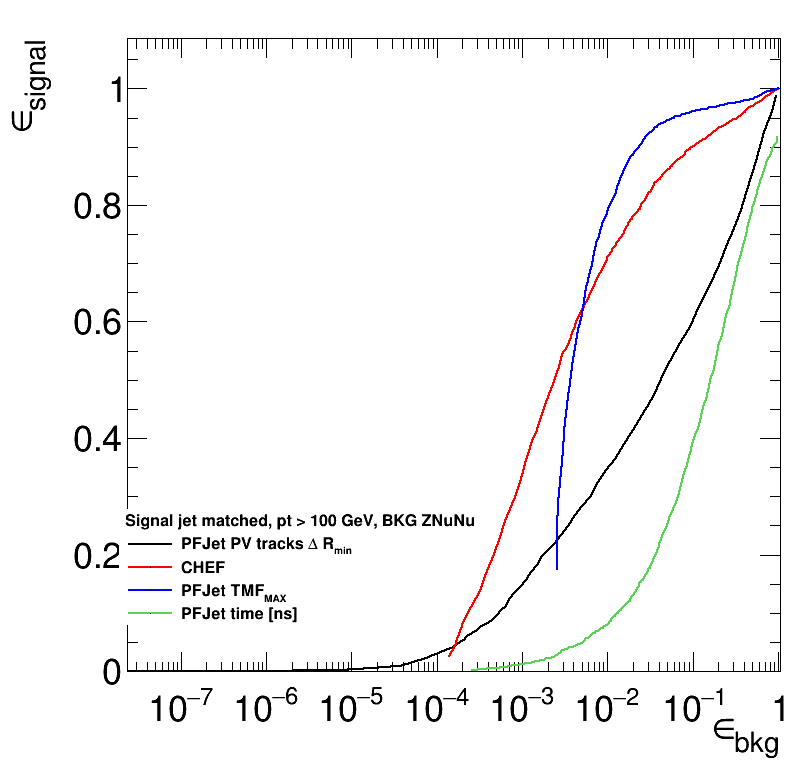

In [57]:
### ROC curve
var_pf = [flat_jet_dr,   flat_jet_chef, flat_jet_tmf, flat_jet_t ]
axis_pf = [['PFJet PV tracks #Delta R_{min}','Events'],  ['CHEF','Events'],['PFJet TMF_{MAX}','Events'] , ['PFJet time [ns]', 'Events'] ]
name_pf = ['pfjetMinDeltaRPVTracks', 'CHEF','pfjetGammaMax_ET', 'pfjetTime'  ]
bins_pf = [[50,0,10], [50,0,1.5],[50,0,1.5],[50,0,10], [50, -5, 5]]
maxs_pf = [10,   1.5, 1.5, 50]

sig_keys = ['H(bb)H(bb), N3N2, 200 GeV, 1 GeV, 1 m',]
qcd_key = 'ZNunu_HT_all, background'
#         'TT_Lep, background',
#         'All, background',
calo = 0
pt_cut =100
for sig_k in sig_keys:
    c = rt.TCanvas('c','c', 800, 800)
    leg = rt.TLegend(0.15,0.19,0.46,0.34)
#     leg = rt.TLegend(0.65,0.19,0.86,0.34)
    leg.SetTextSize(0.022)
    leg.SetBorderSize(0)
    leg.SetEntrySeparation(0.01)
    gr = {}
    purity = {}
    if calo:
        var = var_calo
        name = name_calo
        axis = axis_calo
        maxs = maxs_calo
    else:
        var = var_pf
        name = name_pf
        axis = axis_pf
        maxs = maxs_pf
        
    for i in range(len(var)):
        v = var[i]
        eff = {}
        thre = maxs[i]*np.array(range(1,1000))/1000.0
        if name[i]=='pfjetTime':
            print('IT IS TIME')
            thre = -5 + 10*np.array(range(1,1000))/1000.0
            
        print(maxs[i],name[i],'thre range',np.max(thre),np.min(thre))
        print(name[i])
        for k in tree.keys():
            v = var[i][k]
            print(k,len(v))
            if len(v)==0:
                print('no')
                eff[k] = []
                for th in thre:
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0)
                    else:
                        eff[k].append(1.0)
                eff[k] = np.array(eff[k])
            else:
                eff[k] = []
                for th in thre:
#                     if 'MinDeltaR' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     elif 'Time' in name[i]:
#                         eff[k].append(1.0*np.count_nonzero(v>th)/len(v))
#                     else:
#                         eff[k].append(1.0*np.count_nonzero(v<th)/len(v))
             
                    if 'MinDeltaR' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    elif 'Time' in name[i]:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v>th])/np.sum(trg_flat_w[k]))
                    else:
                        eff[k].append(1.0*np.sum(np.array(trg_flat_w[k])[v<th])/np.sum(trg_flat_w[k]))
                eff[k] = np.array(eff[k])
    #     Plotting ROC curve
        gr[name[i]] = create_TGraph(eff[qcd_key],eff[sig_k],axis_title = ['#epsilon_{bkg}','#epsilon_{signal}'])
        print(len(eff[qcd_key]))
        print(eff[qcd_key][:10])
        print(min(eff[qcd_key]))
        print(max(eff[qcd_key]))
        print(min(eff[qcd_key]))
        print(eff[sig_k][:10])
        print(min(eff[sig_k]))
        print(max(eff[sig_k]))
        gr[name[i]].SetLineColor(std_color_list[i])
        gr[name[i]].SetLineWidth(2)
        gr[name[i]].GetYaxis().SetRangeUser(0.0, 1.0)
        gr[name[i]].GetXaxis().SetLimits(0.0, 1.0)

        leg.AddEntry(gr[name[i]],axis[i][0])

        gr[name[i]].Draw('ac' if i==0 else 'c')

    leg.SetHeader('Signal jet matched, pt > ' +str(pt_cut) + ' GeV, BKG ZNuNu')

    leg.Draw()
    c.SetLogx()
    c.Draw()
    c.SaveAs(out_dir+'ROC_ZNuNu.png')